# Выявление причин возникновения заболеваний сердца (с использованием Random Forest)

In [56]:
import pandas as pd
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Data description
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

Age | Objective Feature | age | int (days)
Height | Objective Feature | height | int (cm) |
Weight | Objective Feature | weight | float (kg) |
Gender | Objective Feature | gender | categorical code |
Systolic blood pressure | Examination Feature | ap_hi | int |
Diastolic blood pressure | Examination Feature | ap_lo | int |
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
Smoking | Subjective Feature | smoke | binary |
Alcohol intake | Subjective Feature | alco | binary |
Physical activity | Subjective Feature | active | binary |
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
All of the dataset values were collected at the moment of medical examination.

In [5]:
data['cholesterol'].unique()

array([1, 3, 2])

In [6]:
data['gluc'].unique()

array([1, 2, 3])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Значений NaN в датасете нет.

Посмотрим столбцы age, height, weight, ap_hi, ap_lo на выбросы.

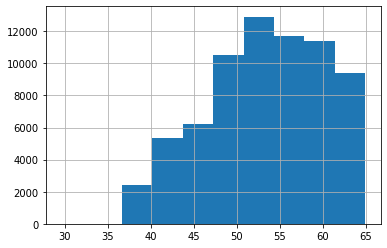

In [8]:
age = data['age']/365
age.hist()

In [9]:
age.min()

29.583561643835615

In [10]:
age.max()

64.96712328767123

По возрасту нет ошибок в датасете. Представлены люди от 29 и до 65 лет.

In [11]:
height = data['height']

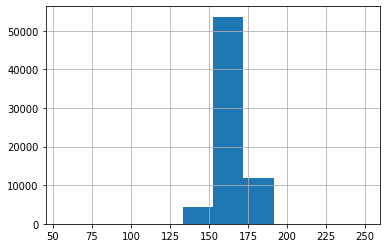

In [12]:
height.hist()

In [13]:
height.min()

55

In [14]:
height.max()

250

В датасете присуствуют взрослые люди очень маленького роста. Удалим их как выбросы:

In [15]:
data = data[data.height >= 130]

In [16]:
weight = data['weight']

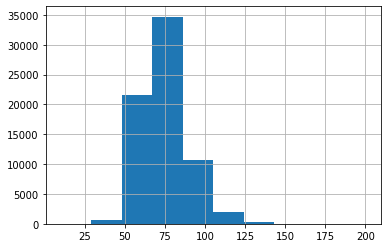

In [17]:
weight.hist()

In [18]:
weight.min()

10.0

In [19]:
weight.max()

200.0

В датасете пристутсвуют взрослые люди с весом менее 45 кг. Будем считать их выбросами и удалим.

In [20]:
data = data[data.weight >=45]

In [21]:
weight = data['weight']
weight.min()

45.0

In [22]:
ap_hi = data['ap_hi']
ap_lo = data['ap_lo']

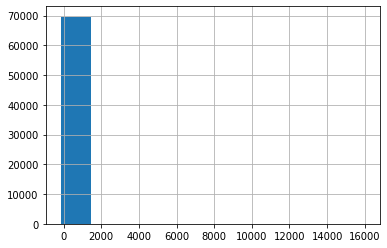

In [23]:
ap_hi.hist()

In [24]:
ap_hi.max()

16020

In [25]:
ap_hi.min()

-150

Видим, что присутствуют аномальные положительные и отрицательные значения для верхнего артериального давления. Возьмем интервал от 50 до 220.

In [26]:
data = data[(data.ap_hi >50) & (data.ap_hi < 220)]
ap_hi = data['ap_hi']
ap_lo = data['ap_lo']

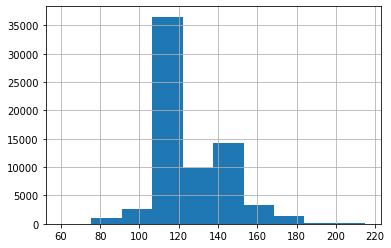

In [27]:
ap_hi.hist()

Из графика видно, что можно брать интервал от 80 до 180:

In [28]:
data = data[(data.ap_hi >= 80) & (data.ap_hi <= 180)]
ap_hi = data['ap_hi']
ap_lo = data['ap_lo']

Теперь посмотрим на нижнюю границу артериального давления:

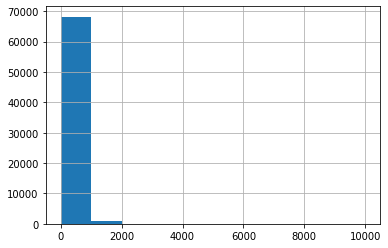

In [29]:
ap_lo.hist()

Видим, что присутствуют аномально низкие и высокие значения для нижнего артериального давления. Возьмем интервал от 0 до 150.

In [30]:
data = data[(data.ap_lo >0) & (data.ap_lo < 150)]
ap_hi = data['ap_hi']
ap_lo = data['ap_lo']

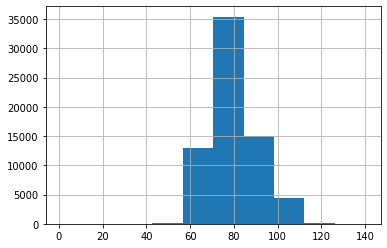

In [31]:
ap_lo.hist()

Видим, что можно брать интервал от 50 до 110.

In [32]:
data = data[(data.ap_lo >= 50) & (data.ap_lo <= 110)]

In [33]:
ap_hi = data['ap_hi']
ap_lo = data['ap_lo']

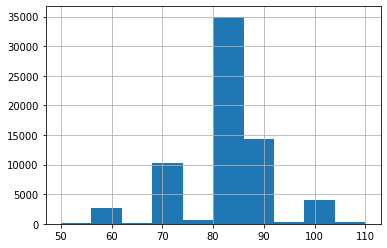

In [34]:
ap_lo.hist()

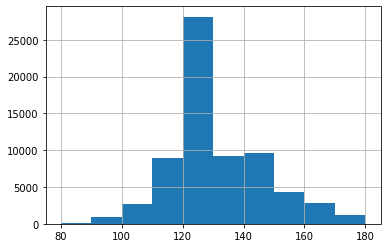

In [35]:
ap_hi.hist()

### Модель Random Forest

Удалим столбец id, так как он не несет никакой смысловой нагрузки для нас и столбец cardio, так как это то, что нам нужно предсказать.

In [36]:
x, y = data.drop(['id', 'cardio'], axis=1), data.cardio

In [46]:
headers = x.columns.values
headers

array(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active'], dtype=object)

In [37]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.588076,1.0,0.316667,0.109677,0.3,0.500000,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.216667,0.258065,0.6,0.666667,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.291667,0.122581,0.5,0.333333,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.325000,0.238710,0.7,0.833333,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.216667,0.070968,0.2,0.166667,0.0,0.0,0.0,0.0,0.0


In [49]:
df_norm.columns = headers
df_norm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.588076,1.0,0.316667,0.109677,0.3,0.500000,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.216667,0.258065,0.6,0.666667,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.291667,0.122581,0.5,0.333333,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.325000,0.238710,0.7,0.833333,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.216667,0.070968,0.2,0.166667,0.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_norm,y, test_size = 0.2, random_state = 42)

In [51]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
from sklearn.metrics import classification_report

model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6886
           1       0.71      0.69      0.70      6681

    accuracy                           0.71     13567
   macro avg       0.71      0.71      0.71     13567
weighted avg       0.71      0.71      0.71     13567



Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


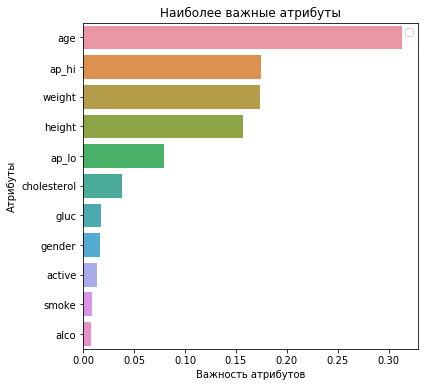

In [53]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Самый важный атрибут с точки зрения Random Forest - это возраст (Age).

Выдвигаем гипотезу о том, что люди старше 55 лет имеют более высокий показатель верхнего артериального давления, чем люди младше 55. Проверим эту гипотезу, используя двухвыборочный t-критерий.

In [65]:
after_55 = data[data.age > 55 *365]['ap_hi']
before_55 = data[data.age <= 55 *365]['ap_hi']

In [71]:
len(after_55)

30208

In [72]:
len(before_55)

37627

In [67]:
after_55.mean()

129.39482918432202

In [68]:
before_55.mean()

123.87243203019109

In [69]:
print(stats.ttest_ind(after_55, before_55))

Ttest_indResult(statistic=45.6410715379772, pvalue=0.0)


Так как p-value < 0.05 мы отвергаем нулевую гипотезу о том, что две выборки одинаковы и приходим к выводу, что статистически люди старше 55 лет имеют более высокое значение кровяного давления.